In [1]:
import cv2
import numpy as np
import torch

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.mplot3d import Axes3D

cmap = mpl.colormaps['tab10']
colors = cmap(np.linspace(0, 1, 10))
markers = ["s","^",">","o","*"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fig_size = (6,3)
print(device)

cpu


In [2]:
def plot_projection(t,x,v=0):
    b = x-v*t
    # Fig (a)
    fig = plt.figure(figsize=(2.8,2.5))
    plt.scatter(x,t, color=colors[0])
    plt.scatter(b, 0*b, color=colors[1])
    plt.legend(["Events", "Projections"], loc=2)
    for k in range(len(x)):
        plt.plot([x[k],b[k]],[t[k],0], ":", color=colors[2])
    plt.xlim([0,10])
    plt.ylim([-0.05,6])
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places
    plt.xlabel("X")
    plt.ylabel("T")
    plt.tight_layout()
    plt.savefig(f"output/v{v:0.2f}_proj.pdf")


def comp_distribution(t,x,v=0, sigma2 = 1.0, show=True):
    b = x-v*t
    z = np.linspace(-30,30,6001)
    pb, pb_i = 0, []
    for k in range(len(b)):
        pb_i.append(np.exp(-(z-b[k])**2/(2*sigma2))/np.sqrt(2*np.pi*sigma2)/len(b))
        pb = pb+pb_i[-1]
    
    power = np.sum(pb*pb)*0.01
    if show:
        print("sum of prob:", np.sum(pb)*0.01)
        print("power of prob:", np.sum(pb*pb)*0.01)
    return z, b, pb, pb_i, power


def plot_distribution(z, v, b, pb, pb_i):
    plt.figure(figsize=(2.8,2))
    plt.plot(z, pb,c=colors[3])
    plt.legend(["MoG"], loc=1)
    plt.fill_between(z, pb,color=colors[6])
    plt.scatter(b, 0*b, color=colors[1])
    for k in range(len(b)):
        plt.plot(z, pb_i[k], '-.',color=colors[5])
        plt.plot([b[k],b[k]],[0,0.05],':',color=colors[8])
        
    plt.xlim([0,10])
    plt.ylim([-0.01,0.3])
    plt.xlabel("b")
    plt.ylabel("p(b)")
    plt.tight_layout()
    plt.savefig(f"output/v{v:0.2f}_dist.pdf")


def test(t,x,v=0.0):
    plot_projection(t,x,v)
    z, b, pb, pb_i, power = comp_distribution(t,x,v)
    plot_distribution(z, v, b, pb, pb_i)
    plt.show()

sum of prob: 1.0000000000000002
power of prob: 0.1467845399030227


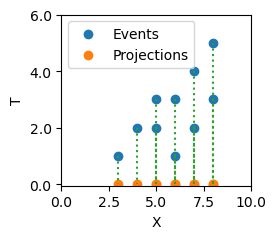

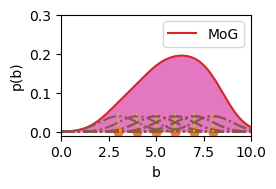

In [3]:
# data
x = np.array([3,4,5,5,6,7,8,6,7,8])
t = np.array([1.0,2.0,3.0,2.0,3.0,4.0,5.0,1.0,2.0,3.0])

test(t,x,v=0.0)

sum of prob: 1.0
power of prob: 0.1788974967995443


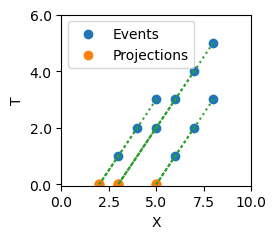

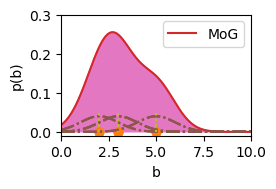

In [4]:
test(t,x,v=1.0)

sum of prob: 1.0000000000000002
power of prob: 0.16610708971840007


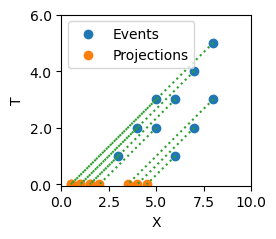

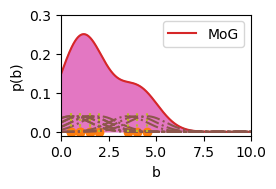

In [5]:
test(t,x,v=1.5)

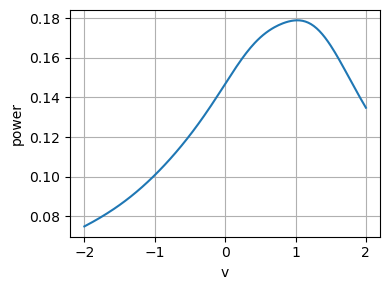

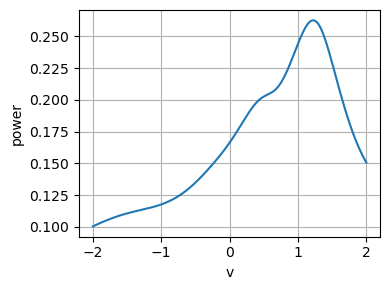

In [6]:
def loss_curve(sigma2=1.0):
    V = np.linspace(-2.0,2.0,201)
    P = []
    for v in V:
        z, b, pb, pb_i, power = comp_distribution(t,x,v, sigma2 = sigma2, show=False)
        P.append(power)
    
    plt.figure(figsize=(4,3))
    plt.plot(V,P)
    plt.grid('on')
    plt.xlabel("v")
    plt.ylabel("power")
    plt.tight_layout()
    plt.savefig(f"output/power_curve.pdf")
    plt.show()

loss_curve()
loss_curve(sigma2=0.25)

In [7]:
def objective1d_origin(x, t, v, sigma2=1.0, tau2=0.0, compute_grad=True, compute_hessian=True):
    """
    Original objective function without temporal smoothing.
    Args:
        v (Tensor): velocities to evaluate, shape (B,)
        x (Tensor): event x-positions, shape (N,)
        t (Tensor): event timestamps, shape (N,)
        sigma2 (float): spatial Gaussian variance
    Returns:
        Tensor: objective values for each v, shape (B,)
    """
    sigma2 = sigma2 + tau2

    v = v[:, None, None]  # shape: (B, 1, 1) for broadcasting
    xij = x[None, None, :] - x[None, :, None]  # x_i - x_j, shape: (1, N, N)
    tij = t[None, None, :] - t[None, :, None]  # t_i - t_j, shape: (1, N, N)
    tij2 = tij * tij               # (1, N, N)

    bx = xij - v * tij  # back-projected spatial offset
    bx2 = bx * bx       # squared offset

    coeff = 1.0 / torch.sqrt(torch.tensor(2 * torch.pi * sigma2, device=x.device))
    exponent = torch.exp(-0.5 * bx2 / sigma2)  # Gaussian kernel

    loss = coeff * torch.mean(exponent, dim=(1, 2))  # average over all i, j pairs

    J, H = None, None
    if compute_grad:
        J = coeff*torch.mean(bx * tij * exponent, dim=(1, 2))/sigma2
    if compute_hessian:
        H = coeff*torch.mean(exponent * tij2 * (bx2 / sigma2 ** 2 - 1 / sigma2), dim=(1, 2))
    return loss, J, H
    

def objective1d_smooth(x,t,v,sigma2=1.0, tau2=1.0, compute_grad=True, compute_hessian=True):
    """
    Smoothed objective function with time-dependent Gaussian variance.
    Args:
        x (Tensor): event x-positions, shape (N,)
        t (Tensor): event timestamps, shape (N,)
        v (Tensor): velocities to evaluate, shape (B,)
        sigma2 (float): base spatial variance
        tau2 (float): temporal smoothness coefficient
    Returns:
        Tensor: objective values for each v, shape (B,)
    """
    v = v[:, None, None]  # shape: (B, 1, 1)
    xij = x[None, None, :] - x[None, :, None]  # shape: (1, N, N)
    tij = t[None, None, :] - t[None, :, None]  # shape: (1, N, N)
    tij2 = tij * tij  # square of time difference
    
    bx = xij - v * tij  # back-projected spatial offset， shape: (B, N, N)
    bx2 = bx * bx       # squared offset
    
    denom = sigma2 + tij2 * tau2  # total variance with temporal smoothing
    coeff = 1.0 / torch.sqrt(2 * torch.pi * denom)  # adaptive normalization
    exponent = torch.exp(-0.5 * bx2 / denom)  # Gaussian kernel with variable width
    
    loss = torch.mean(coeff * exponent, dim=(1, 2))  # mean density over all pairs
    
    J, H = None, None
    if compute_grad:
        J = torch.mean(coeff * bx * tij * exponent/denom, dim=(1, 2))
    if compute_hessian:
        H = torch.mean(coeff * exponent * tij2 * (bx2 / denom ** 2 - 1 / denom), dim=(1, 2))
    return loss, J, H

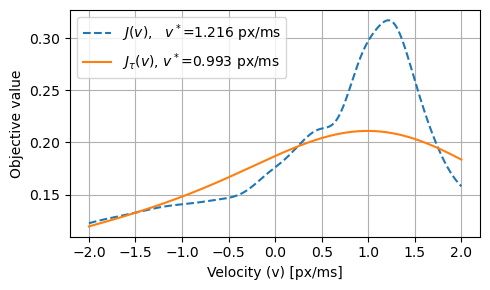

In [8]:
def plot_curves(x,t):
    x1 = torch.tensor(x, dtype=torch.float32)  # shape (N,)
    t1 = torch.tensor(t, dtype=torch.float32)
    v0 = torch.linspace(-2, 2, 4001)
    sigma2 = 0.25
    tau2 = 1.0
    loss_org, J, H = objective1d_origin(x1, t1, v0, sigma2=sigma2, tau2=0.0)
    loss_sa, J, H = objective1d_smooth(x1, t1, v0, sigma2=sigma2, tau2=tau2)
    
    plt.figure(figsize=(5,3))
    plt.plot(v0.numpy(), loss_org.numpy(),'--', color=colors[0], label=f"$J(v)$, $\;$ $v^*$={v0[torch.argmax(loss_org)]:.3f} px/ms")
    plt.plot(v0.numpy(), loss_sa.numpy(), color=colors[1], label=f"$J_\\tau(v)$, $v^*$={v0[torch.argmax(loss_sa)]:.3f} px/ms")
    plt.xlabel("Velocity (v) [px/ms]")     # x轴标签
    plt.ylabel("Objective value")  # y轴标签
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"output/Fig2_diff_loss_funcs.pdf")
    plt.show()

plot_curves(x,t)

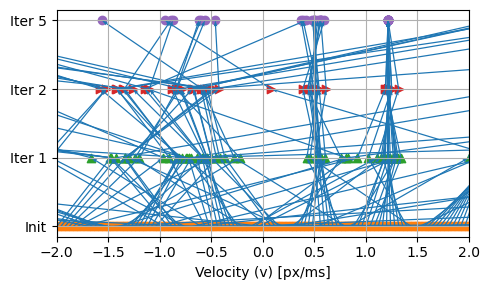

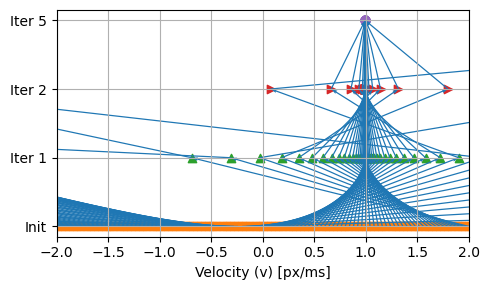

In [9]:
def test_updates(x,t,objective1d,sigma2=0.25, tau2=0.0):
    x1 = torch.tensor(x, dtype=torch.float32)  # shape (N,)
    t1 = torch.tensor(t, dtype=torch.float32)
    v0 = torch.linspace(-2, 2, 4001)

    # Evaluate both objective functions
    loss, J, H = objective1d(x1, t1, v0, sigma2=sigma2, tau2=tau2)
    v1 = v0 - J/H

    lossx, J, H = objective1d(x1, t1, v1, sigma2=sigma2, tau2=tau2)
    v2 = v1 - J/H

    vn = v2
    for i in range(3):
        lossx, J, H = objective1d(x1, t1, vn, sigma2=sigma2, tau2=tau2)
        vn = vn - J/H
    
    v0_s = v0.numpy()[::40]
    v1_s = v1.numpy()[::40]
    v2_s = v2.numpy()[::40]
    vn_s = vn.numpy()[::40]
    plt.figure(figsize=(5,3))
    plt.scatter(v0_s,0*v0_s,color=colors[1],marker=markers[0])
    plt.scatter(v1_s,1+0*v0_s,color=colors[2],marker=markers[1])
    plt.scatter(v2_s,2+0*v0_s,color=colors[3],marker=markers[2])
    plt.scatter(vn_s,3+0*v0_s,color=colors[4],marker=markers[3])
    plt.grid("on")
    plt.quiver(v0_s, 0*v0_s, v1_s-v0_s,1+0*v0_s, angles='xy', scale_units='xy', scale=1,width=0.003,color=colors[0])
    plt.quiver(v1_s, 0*v1_s+1, v2_s-v1_s,1+0*v0_s, angles='xy', scale_units='xy', scale=1,width=0.003,color=colors[0])
    plt.quiver(v2_s, 0*v2_s+2, vn_s-v2_s,1+0*v0_s, angles='xy', scale_units='xy', scale=1,width=0.003,color=colors[0])
    plt.xlim([np.min(v0_s), np.max(v0_s)])
    plt.xlabel("Velocity (v) [px/ms]")
    # plt.ylabel("Iteration Step")
    plt.yticks([0, 1, 2, 3], ["Init", "Iter 1", "Iter 2", "Iter 5"])
    plt.tight_layout()
    plt.savefig(f"output/Fig2_iter_updates{objective1d.__name__}.pdf")
    plt.show()

test_updates(x,t,objective1d_origin,sigma2=0.25, tau2=0.0)
test_updates(x,t,objective1d_smooth,sigma2=0.25, tau2=1.0)